In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch

def safe_float_conversion(data):
    try:
        return data.astype(float)
    except ValueError:
        # Handle or log the exception if needed
        return data

def recursively_convert_to_float(data):
    # Check if data is a numpy array (which includes structured arrays and nested arrays)
    if isinstance(data, np.ndarray):
        if data.dtype == 'O':  # For object type arrays, iterate over each element
            return np.array([recursively_convert_to_float(item.squeeze()) for item in data], dtype=float)
        else:  # Directly convert to float for other numeric types
            return data.astype(float)
    else:  # Base case for non-array data
        return float(data)

In [2]:
incident_energy = 260

In [3]:
exp_mat = scipy.io.loadmat(f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/Data_folded{incident_energy:d}meV.mat')

In [4]:
flattened_data = exp_mat['data'][0][0].copy()

In [5]:
dict_out = {}

for name in flattened_data.dtype.names:
    if name == 's':
        dict_out['S'] = torch.from_numpy(flattened_data[name].astype(float))
    elif name == 'p':
        dict_out['grid'] = {}
        for _key, _array in zip(['h_grid', 'k_grid', 'l_grid', 'w_grid'], flattened_data[name][0]):
            dict_out['grid'][_key] = torch.from_numpy((_array.astype(float)[:-1] + _array.astype(float)[1:]).squeeze() / 2)

In [6]:
w_cutoff = 150
_w_grid = dict_out['grid']['w_grid']
dict_out['grid']['w_grid'] = _w_grid[_w_grid <= w_cutoff]
dict_out['S'] = dict_out['S'][...,_w_grid <= w_cutoff]

In [7]:
# torch.save(dict_out, f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')

In [8]:
h_grid = dict_out['grid']['h_grid']
k_grid = dict_out['grid']['k_grid']
l_grid = dict_out['grid']['l_grid']
w_grid = dict_out['grid']['w_grid']

sqw_base = dict_out['S']

In [9]:
sqw_fold = torch.zeros((len(h_grid)-1)*2 + 1, len(k_grid), len(l_grid), len(w_grid))
print(sqw_fold.shape)

sqw_fold[sqw_fold.shape[0]//2:, :] = sqw_base
sqw_fold[:, sqw_fold.shape[1]//2:] += sqw_base[:,:].permute(1, 0, 2, 3)
sqw_fold += sqw_fold.flip(0).flip(1)
for i in range(sqw_fold.shape[0]):
    # Flipped diagonal (or anti-diagonal)
    sqw_fold[i, i] /= 2
    sqw_fold[i, sqw_fold.shape[0]-i-1] /= 2
    
sqw_fold_mean = sqw_fold.sum(dim=-1).sum(dim=-1) / ((sqw_fold > 1e-10).sum(dim=-1).sum(dim=-1))
# sqw_fold_mean = sqw_fold.sum(dim=-1).sum(dim=-1)

torch.Size([121, 121, 30, 66])


Text(0, 0.5, '$k$')

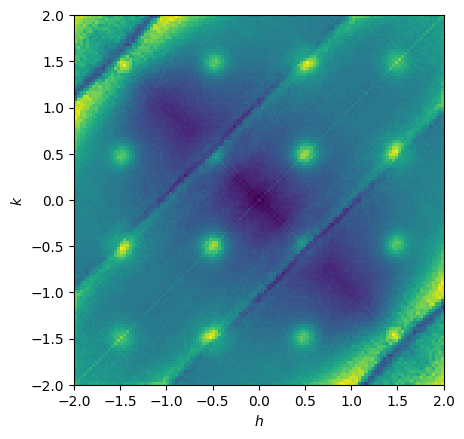

In [10]:
# sqw_base_mean = sqw_base.sum(dim=-1).sum(dim=-1).T / ((sqw_base > 1e-10).sum(dim=-1).sum(dim=-1).T)
fig, ax = plt.subplots(1, 1, sharey=True)
ax.imshow(
    sqw_fold_mean.T, 
    origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')

In [11]:
if incident_energy == 260:
    h_grid_updated = torch.cat([-h_grid[1:].flip(dims=(0,)), h_grid], dim=0)
    k_grid_updated = k_grid
elif incident_energy == 190:
    h_grid_updated = torch.cat([-h_grid[1:-1].flip(dims=(0,)), h_grid[:-1]], dim=0)
    k_grid_updated = k_grid[:-1]

dict_save = {
    'grid': {
        'h_grid': h_grid_updated,
        'k_grid': k_grid_updated,
        'l_grid': l_grid,
        'w_grid': dict_out['grid']['w_grid']
    },
    'S': sqw_fold,
}

In [12]:
torch.save(dict_save, f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')

Text(0, 0.5, '$k$')

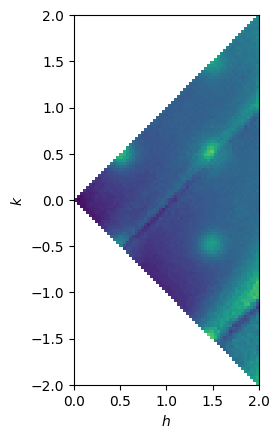

In [15]:
fig, ax = plt.subplots(1, 1, sharey=True)
ax.imshow(
    sqw_base[...,:55].sum(dim=-1).sum(dim=-1).T / ((sqw_base[...,:55] > 0).sum(dim=-1).sum(dim=-1).T), 
    origin='lower', vmin=2, vmax=10, extent=[0, 2, -2, 2])
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')

In [9]:
sqw_base_expanded = torch.cat([torch.zeros((sqw_base.shape[0]-1,)+sqw_base.shape[1:]), sqw_base], dim=0)

In [10]:
sqw_base_merged = sqw_base_expanded + sqw_base_expanded.permute(1,0,2,3)
for i in range(sqw_base_merged.shape[0]):
    # Flipped diagonal (or anti-diagonal)
    sqw_base_merged[i, i] /= 2

Text(0, 0.5, '$k$')

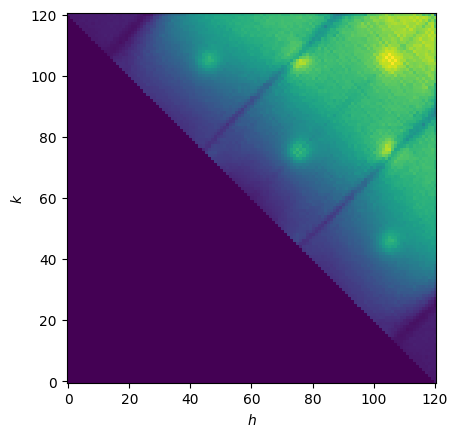

In [11]:
fig, ax = plt.subplots(1, 1, sharey=True)
ax.imshow(
    sqw_base_merged.sum(-1).sum(-1).T, 
    origin='lower')
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')

In [12]:
h_num = (h_grid.shape[0] - 1) * 4 + 1
k_num = h_num

In [13]:
sqw_total = torch.zeros((h_num, k_num,) + sqw_base.shape[2:])

In [14]:
sqw_total[:h_num//2+1, :k_num//2+1] = sqw_base_merged
sqw_total[h_num//2:, k_num//2:] = sqw_base_merged.flip(dims=(0,1))

In [15]:
sqw_total[:h_num//2+1, k_num//2:] = sqw_base_merged
sqw_total[h_num//2:, :k_num//2+1] = sqw_base_merged.flip(dims=(0,1))

Text(0, 0.5, '$k$')

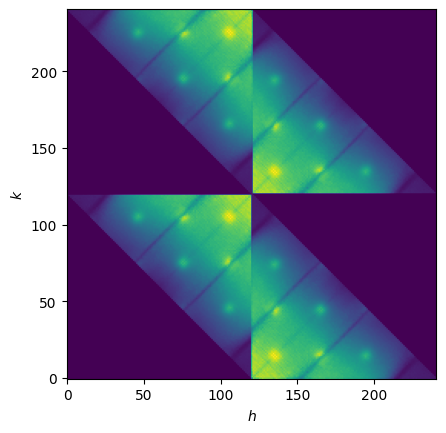

In [16]:
fig, ax = plt.subplots(1, 1, sharey=True)
ax.imshow(
    sqw_total.sum(dim=-1).sum(dim=-1).T,
    origin='lower')
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')

In [8]:
if incident_energy == 260:
    sqw_com = torch.cat([sqw_base[1:,:].flip(dims=(0,1)), sqw_base[:,:]], dim=0)
    h_grid_updated = torch.cat([-h_grid[1:].flip(dims=(0,)), h_grid], dim=0)
    k_grid_updated = k_grid
elif incident_energy == 190:
    sqw_com = torch.cat([sqw_base[1:-1,:-1].flip(dims=(0,1)), sqw_base[:-1,:-1]], dim=0)
    h_grid_updated = torch.cat([-h_grid[1:-1].flip(dims=(0,)), h_grid[:-1]], dim=0)
    k_grid_updated = k_grid[:-1]
print(sqw_com.shape)

torch.Size([121, 121, 30, 91])


In [9]:
sqw_tot = (sqw_com.permute(1,0,2,3) + sqw_com) / 2
for i in range(sqw_tot.shape[0]):
    # Main diagonal
    sqw_tot[i, i] /= 2
    if i != sqw_tot.shape[0] // 2:
        # Flipped diagonal (or anti-diagonal)
        sqw_tot[i, sqw_tot.shape[0]-1-i] /= 2

print(sqw_tot.shape)

torch.Size([121, 121, 30, 91])


In [10]:
sqw_tot_hat = (sqw_tot + sqw_tot.flip((0,))) / 2

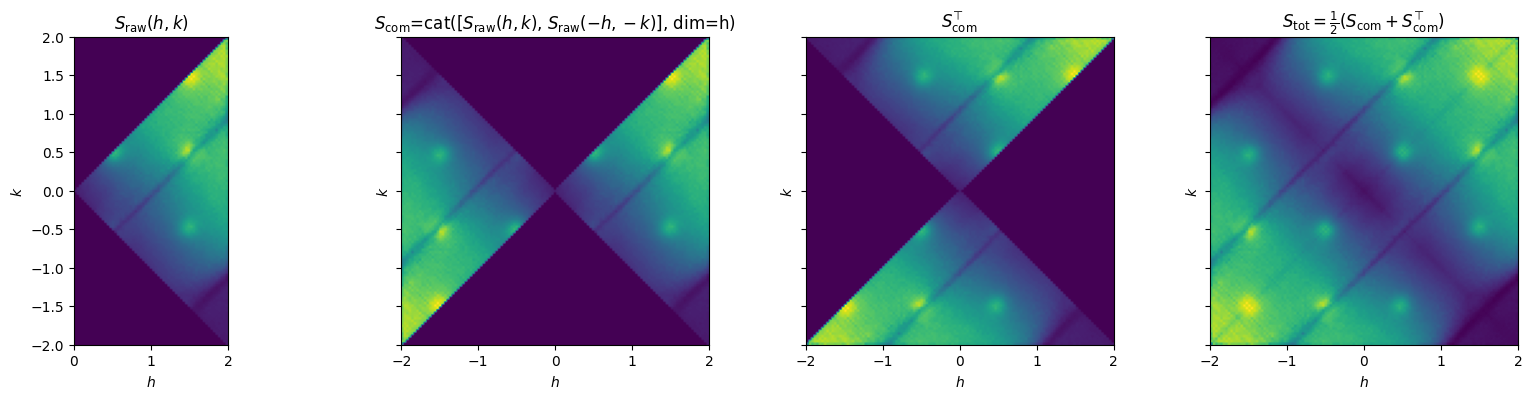

In [84]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(20, 4))

ax = axes[0]
ax.imshow(
    sqw_base.sum(dim=-1).sum(dim=-1).T, 
    extent=[h_grid.min(), h_grid.max(), k_grid.min(), k_grid.max()],
    origin='lower')
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')
ax.set_title('$S_{\mathrm{raw}}(h,k)$')

ax = axes[1]
ax.imshow(
    sqw_com.sum(dim=-1).sum(dim=-1).T, 
    extent=[k_grid.min(), k_grid.max(), k_grid.min(), k_grid.max()],
    origin='lower')
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')
ax.set_title('$S_{\mathrm{com}}$=cat([$S_{\mathrm{raw}}(h,k)$, $S_{\mathrm{raw}}(-h,-k)$], dim=h)')

ax = axes[2]
ax.imshow(
    sqw_com.sum(dim=-1).sum(dim=-1), 
    extent=[k_grid.min(), k_grid.max(), k_grid.min(), k_grid.max()],
    origin='lower')
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')
ax.set_title(r'$S_{\mathrm{com}}^{\top}$')

ax = axes[3]
ax.imshow(
    sqw_tot.sum(dim=-1).sum(dim=-1).T, 
    extent=[k_grid.min(), k_grid.max(), k_grid.min(), k_grid.max()],
    origin='lower')
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')
ax.set_title(r'$S_{\mathrm{tot}} = \frac{1}{2}(S_{\mathrm{com}} + S_{\mathrm{com}}^{\top})$')

fig.savefig(f'figures/temp_figures/exp_data_process_{incident_energy:d}meV.png', dpi=200, bbox_inches='tight')

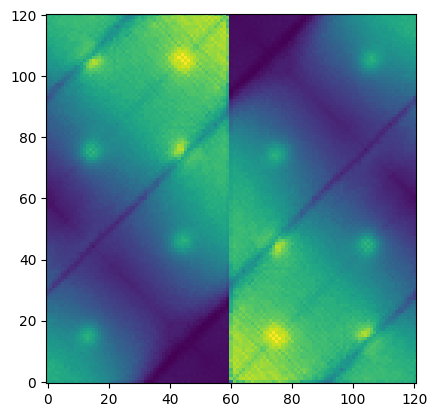

In [90]:
sqw_tot_shifted = torch.roll(sqw_tot, shifts=(60,), dims=(0,))
plt.imshow(sqw_tot_shifted.sum(-1).sum(-1).T, origin='lower')

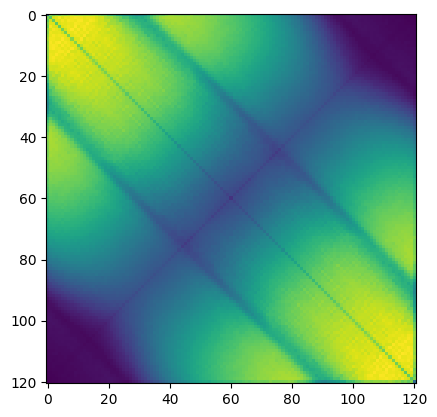

In [12]:
plt.imshow((sqw_tot>0).sum(-1).sum(-1))

In [13]:
# dict_save = {
#     'grid': {
#         'h_grid': h_grid_updated,
#         'k_grid': k_grid_updated,
#         'l_grid': l_grid,
#         'w_grid': dict_out['grid']['w_grid']
#     },
#     'S': sqw_tot_hat,
# }

In [14]:
# torch.save(dict_save, f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')